In [131]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from torchvision import transforms, models
from PIL import Image

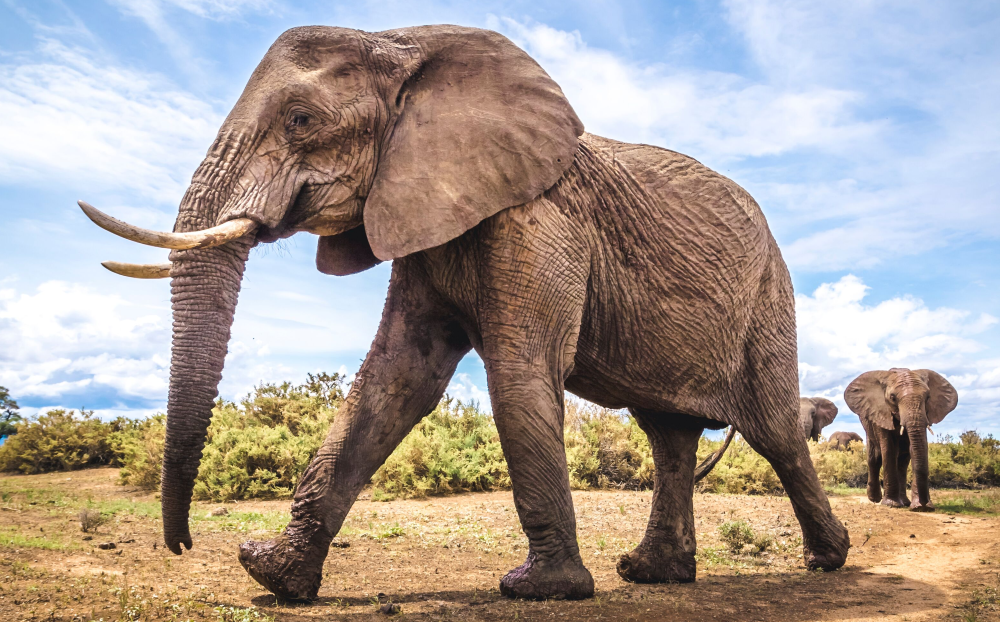

In [6]:
image_ = Image.open("./elephant.png")
image_

In [300]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

"""
Transforming input for forward pass.
"""

image = transforms.Resize(224)(image_)
image = transforms.CenterCrop((224, 224))(image)
image = transforms.ToTensor()(image)
image = transforms.Normalize(mean, std)(image)
image = image.reshape(1,3,224,224)

In [301]:
"""
Transform to undo the above transforms.
(Except cropping and resize)
"""
untensor = lambda tensor:np.uint8((tensor.squeeze().numpy()*std.reshape(3,1,1)+mean.reshape(3,1,1))*255).transpose(1,2,0)

plt.imshow(untensor(image))
plt.axis('off')
plt.show()

In [312]:
"""
Helper to plot a grid of images
plots all channels separately as 
greyscale.
"""
def plot_grid(img, r, c,figsize=(15,15)):
    plt.figure(figsize=figsize)
    for i, act in enumerate(img):
        plt.subplot(r,c,i+1)
        plt.imshow(act, cmap="Greys_r")
        plt.axis('off')
    plt.show()

    
"""
Scale from 0 to 255
"""
def sc255(im):
    im = im.copy()
    im -= im.min()
    im /= im.max()
    im *= 255
    im = np.uint8(im)
    return im

In [304]:
"""
Get the model
pass the image through it 
check the output target.
[ImageNet Class Labels](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)
"""

model = models.resnet18(pretrained=True)
model.eval();
torch.set_grad_enabled(False)
class_index = model(image).squeeze().argmax().item()
print("386: 'African elephant, Loxodonta africana' :: predicted :",class_index)

# Spreading out the layers.
chl = [*model.children()]

386: 'African elephant, Loxodonta africana' :: predicted : 386


# Layer Outputs

## First Layer
```
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
```
- Output dimensions are large enough to visualize, and a square number too, how serendipitous.
- Dimensions: (64, 112, 112)
- The batchnormed output looks the same, this maybe becuase the images aren't 0 - 255 shifted

In [336]:
"""
Images are 0 to 255 scaled
"""
img1 = sc255(chl[0](image).squeeze().numpy())
plot_grid(img1,8,8)

## First conv layer with BatchNorm, ReLU and MaxPool
```
   Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   ReLU(inplace=True)
   MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)j
```
- Dimensions (64,56,56) halved by MaxPool2d
- Due to ReLU now black images (0 values).

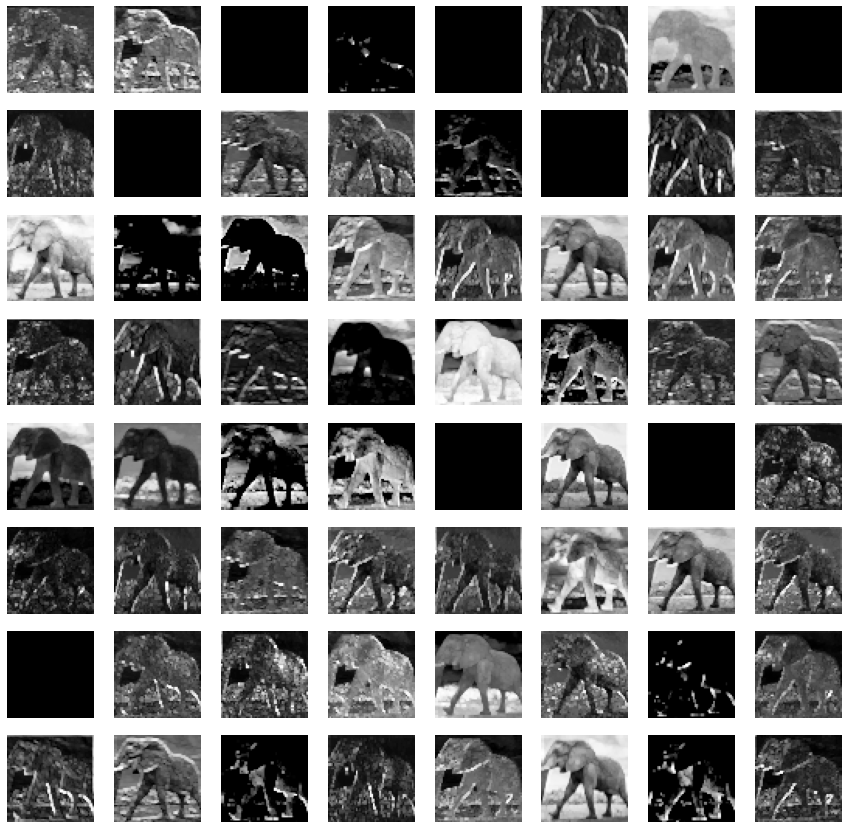

In [339]:
img2 = nn.Sequential(*chl[:4])(image).squeeze().numpy()
plot_grid(img2, 8, 8)

In [185]:
ch_sum1 = img2.sum(dim=(1,2))
print(f"zero activations: {(ch_sum1 == 0).sum().item()}")
idx_max = ch_sum1.argmax()

zero activations: 12


In [198]:
def splot(i,r,c,img):
    plt.subplot(r,c,i)
    plt.imshow(img, cmap="Greys_r")
    plt.axis('off')

In [200]:
"""
This strange blurred activation has the highest 
value.
"""
plt.figure(figsize=(15,5))
splot(1,1,2,img1[idx_max]) # Only first
splot(2,1,2,img2[idx_max]) # After MaxPool

## Remaining activations (conv layer outputs)
The outputs of conv layers get more and more abstract as one moves deeper through the 
layers. 

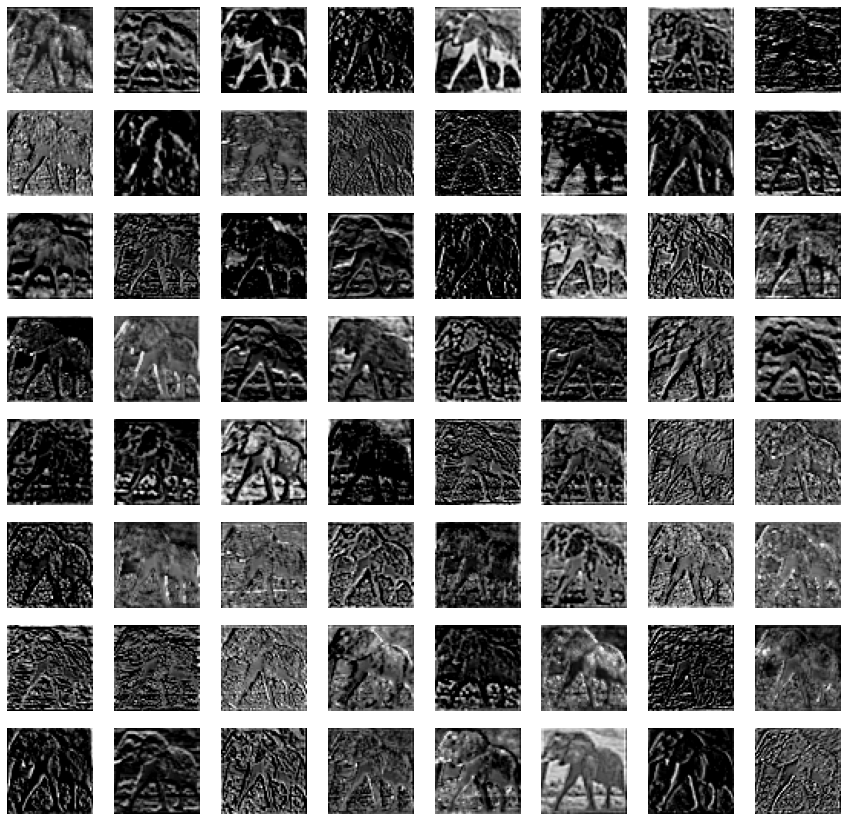

In [225]:
img4 = nn.Sequential(*chl[:5])(image).squeeze() # torch.Size([64, 56, 56])
plot_grid(img4, 16, 8, figsize=(15,30))

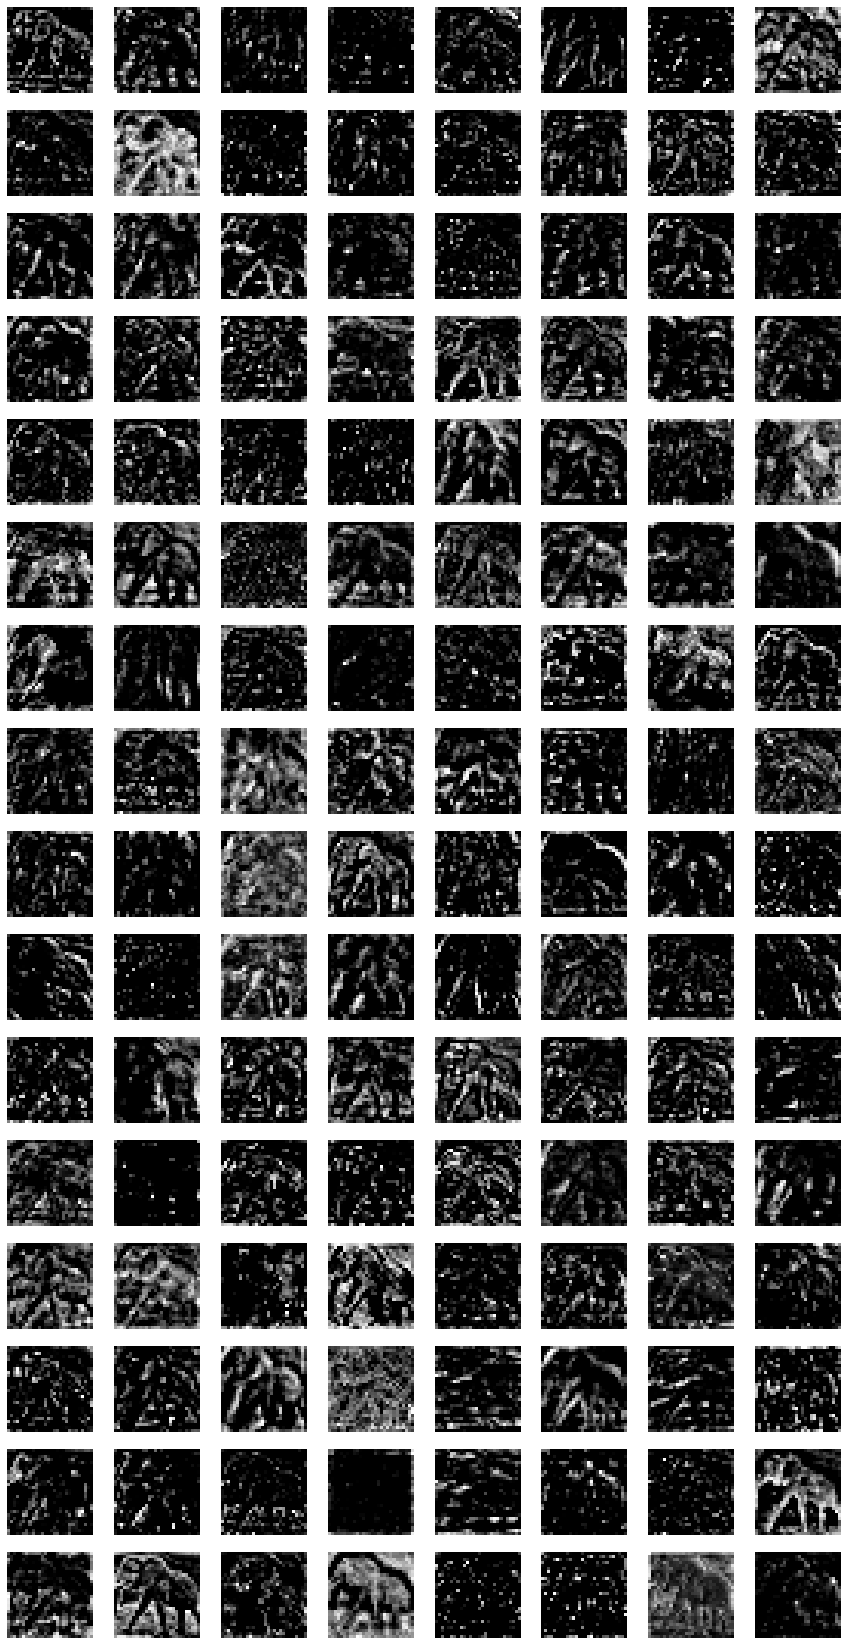

In [236]:
img5 = nn.Sequential(*chl[:6])(image).squeeze() # torch.Size([128, 28, 28])
plot_grid(img5, 16, 8, figsize=(15,30))

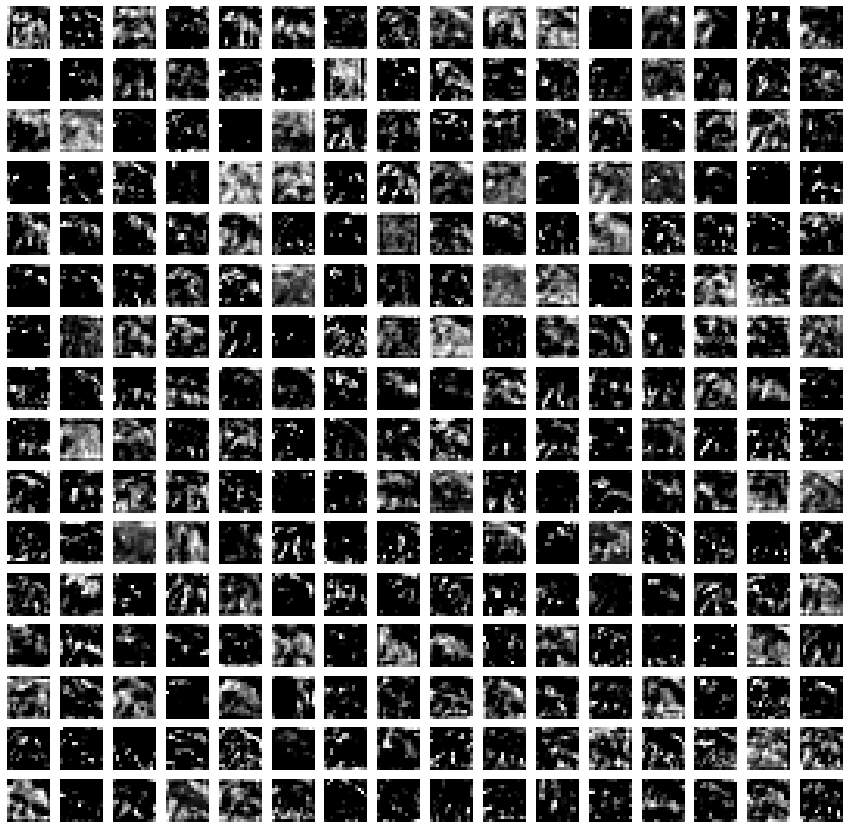

In [237]:
img6 = nn.Sequential(*chl[:7])(image).squeeze() # torch.Size([256, 14, 14])
plot_grid(img6, 16, 16, figsize=(15,15))

In [242]:
img7 = nn.Sequential(*chl[:8])(image).squeeze() # torch.Size([512, 7, 7])
plot_grid(img7, 32, 16, figsize=(15,30))

## Visualizing the filters 

In [343]:
def sc2552(im):
    im = im.copy()
    im -= im.min(axis=(1,2,3)).reshape(-1,1,1,1)
    im /= im.max(axis=(1,2,3)).reshape(-1,1,1,1)
    im *= 255
    im = np.uint8(im)
    return im

In [344]:
c1parm = [*chl[0].parameters()][0].detach().numpy()
c1parm = sc2552(c1parm)

- First conv layer filters on the left and the images they produce on the right.
- Filter shape = `(64, 3, 7, 7)`
- Image shape = `(64, 112, 112)`

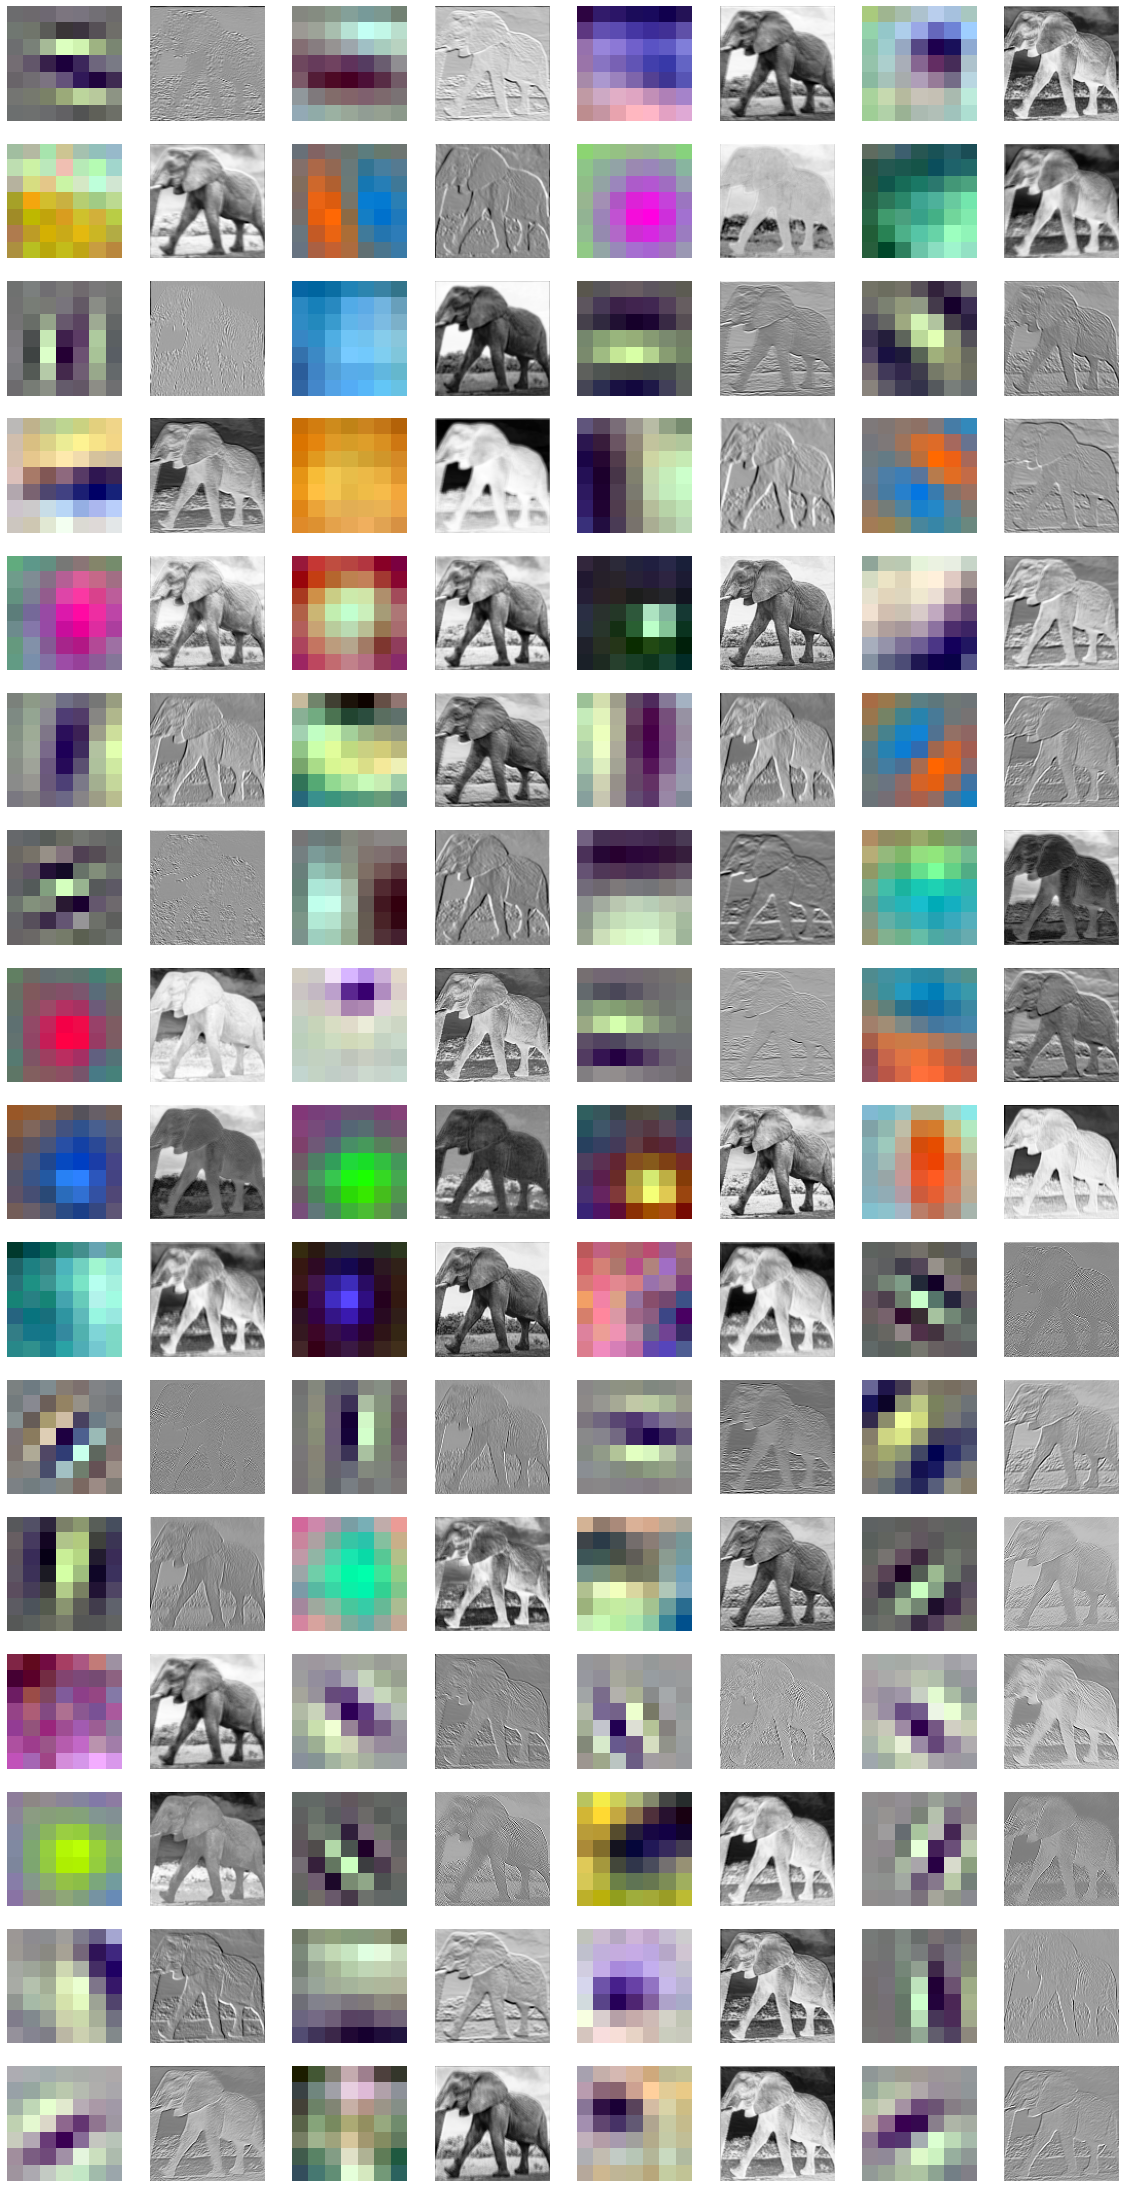

In [368]:
plt.figure(figsize=(20,40))
for j,i in enumerate(range(0,128,2)):
    plt.subplot(16,8,i+1)
    plt.imshow(c1parm[j].transpose(1,2,0))
    plt.axis('off')
    splot(i+2,16,8,img1[j])

## Something Else

In [377]:
fl = [*chl[0].parameters()][0]

In [379]:
fl.shape

torch.Size([64, 3, 7, 7])

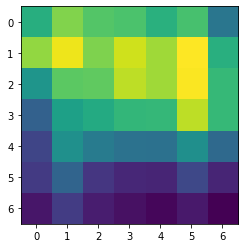

In [396]:
plt.imshow(img7[481])

In [423]:
temp = nn.Sequential(*chl[:5])
timg = temp(image).squeeze().numpy()

temp

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

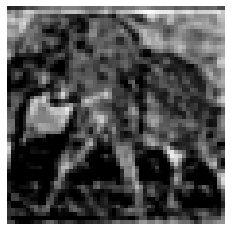

1.0096126

In [475]:
"""
Considering the first channel in the output
of (compound) layer (5)
"""
ch = 4
fmap = timg[ch]
plt.imshow(fmap, cmap="Greys_r")
plt.axis('off')
plt.show()

timg[4,24,20] # What causes this to spike up?